In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import re
import unicodedata
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

**Pull in the dataset**

In [2]:
df = pd.read_json('data/raw/readme_data200.json')

In [3]:
import src.prepare as prepare

**Clean up the language column to remove the numeric values using function from prep file**

In [4]:
df = prepare.clean_language(df)

**Check to find ranges of each language in order to evenly split for training exploration**

In [5]:
#javascript(0-48), python(49-98), java(99-148), c++(149-198)

In [6]:
train = df.iloc[0:30]

In [7]:
train = train.append(df.iloc[49: 79])

In [8]:
train = train.append(df.iloc[99: 129])

In [9]:
train = train.append(df.iloc[149: 179])

**Check to ensure training data is evenly split**

In [10]:
train.language.value_counts()

C++           30
Python        30
JavaScript    30
Java          30
Name: language, dtype: int64

**Use clean function to apply to the readme contents for each language**

In [11]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']


def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower().strip())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

**Splitting the readme text up by language**

In [12]:
js_words = clean(''.join(train[train.language == 'JavaScript'].readme))
python_words = clean(''.join(train[train.language == 'Python'].readme))
java_words = clean(''.join(train[train.language == 'Java'].readme))
c_words = clean(''.join(train[train.language == 'C++'].readme))
all_words = clean(''.join(train.readme))

**Turning into a Pandas series, which will be used to get the frequency of each word**

In [13]:
js_freq = pd.Series(js_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
java_freq = pd.Series(java_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

**Create a dataframe with our word counts**

In [14]:
word_counts = (pd.concat([all_freq, js_freq, python_freq, java_freq, c_freq ], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'c++'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(20)

,all,javascript,python,java,c++
0,70,3,44,21,2
00985589,2,0,2,0,0
01,2,1,0,0,1
011,1,1,0,0,0
011122100,1,1,0,0,0
012,1,1,0,0,0
0120,1,0,0,1,0
01exceptionclass,1,0,0,0,1
02,2,0,0,0,2
020,1,1,0,0,0


**Sort values to find the most frequently occuring words**

In [15]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,javascript,python,java,c++
data,393,58,237,70,28
file,263,52,81,100,30
r,247,0,247,0,0
project,223,26,87,79,31
install,186,73,58,24,31
run,183,59,61,28,35
use,182,55,58,38,31
using,176,27,85,34,30
new,169,30,69,55,15
example,156,15,75,51,15


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

**Visualize the proportion of the most frequent words by language**

Text(0.5, 1.0, 'Proportion of Javascript, Python, Java, and C++ for the 20 most common words')

<Figure size 864x864 with 0 Axes>

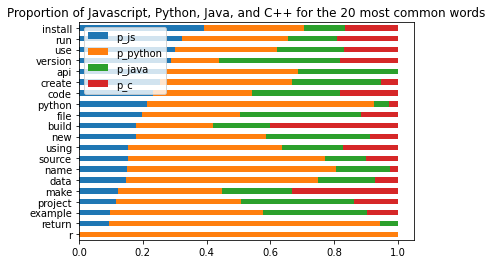

In [17]:
plt.figure(figsize=(12,12))
(word_counts
 .assign(p_js=word_counts.javascript / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_c=word_counts['c++'] / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_python', 'p_java', 'p_c']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))
plt.title('Proportion of Javascript, Python, Java, and C++ for the 20 most common words')

# Create our WordClouds 

In [18]:
from wordcloud import WordCloud


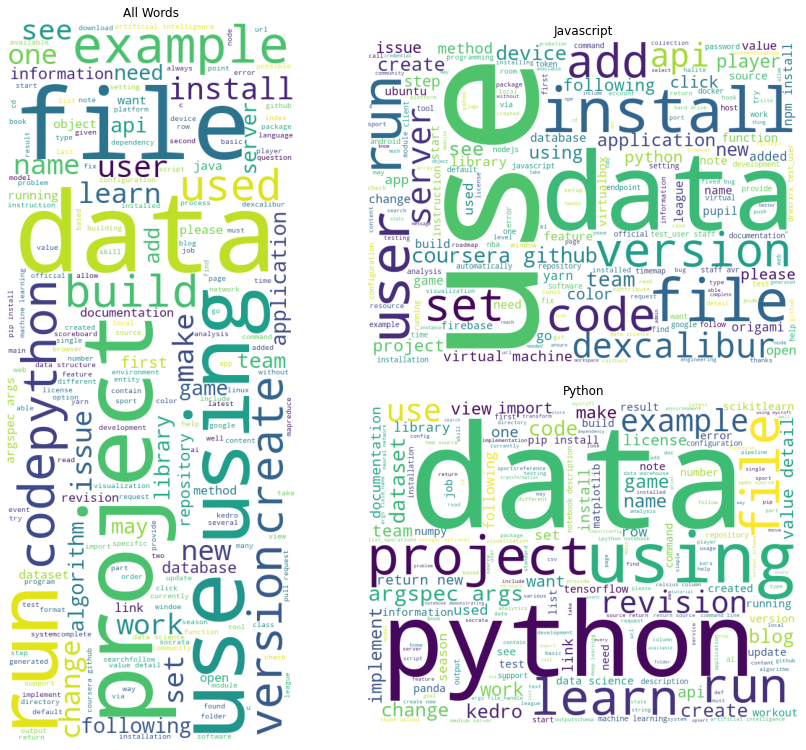

In [19]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
js_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(js_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_words))
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(java_words))
c_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(c_words))



plt.figure(figsize=(12, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(js_cloud)
axs[2].imshow(python_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Javascript')
axs[2].set_title('Python')

for ax in axs: ax.axis('off')

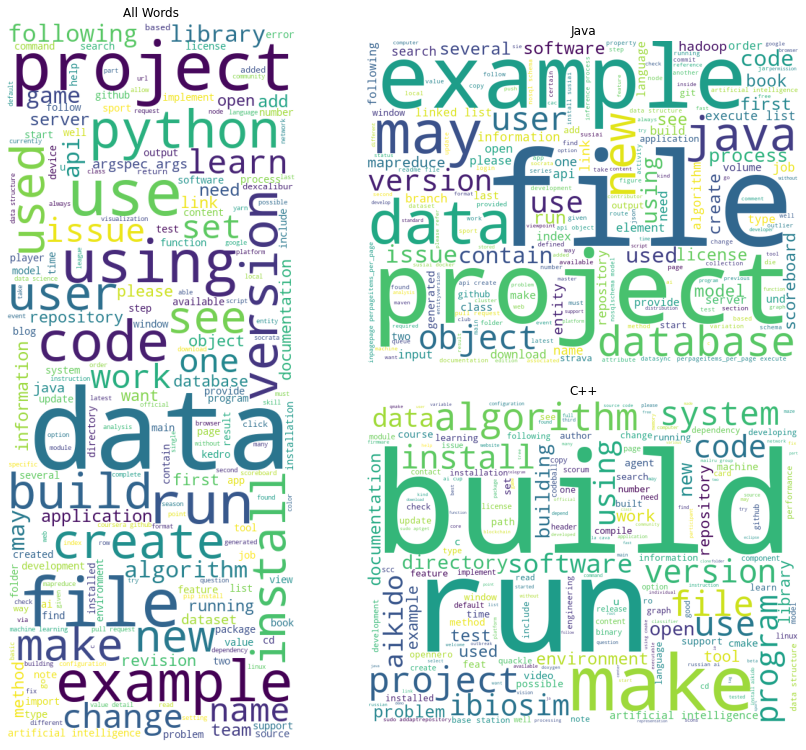

In [20]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
js_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(js_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_words))
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(java_words))
c_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(c_words))



plt.figure(figsize=(12, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(java_cloud)
axs[2].imshow(c_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Java')
axs[2].set_title('C++')

for ax in axs: ax.axis('off')

# Bi-Grams
- Find out which words appear most frequently together for each language

In [21]:
#Javascript
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts(ascending=False)
                      .head(20))

top_20_js_bigrams.head()

(coursera, github)    33
(virtual, machine)    23
(npm, install)        20
(test_user, staff)    17
(29, avr)             17
dtype: int64

In [22]:
#Python
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(argspec, args)    56
(value, 0)         31
(return, new)      24
(pip, install)     23
(data, science)    21
dtype: int64

In [23]:
#Java
top_20_java_bigrams = (pd.Series(nltk.ngrams(java_words, 2))
                      .value_counts()
                      .head(20))

top_20_java_bigrams.head()

(execute, list)                        20
(linked, list)                         18
(artificial, intelligence)             16
(inpagepage, perpageitems_per_page)    14
(inference, process)                   14
dtype: int64

In [24]:
#C++
top_20_c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(20))

top_20_c_bigrams.head()

(artificial, intelligence)    14
(base, station)                9
(data, structure)              9
(ai, cup)                      8
(sudo, addaptrepository)       8
dtype: int64

# Visualize

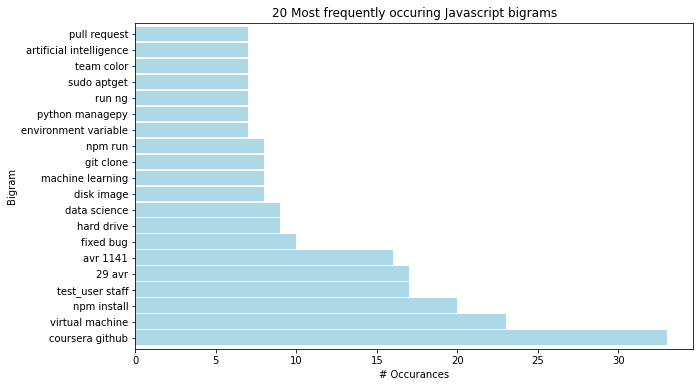

In [25]:
top_20_js_bigrams.plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Javascript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

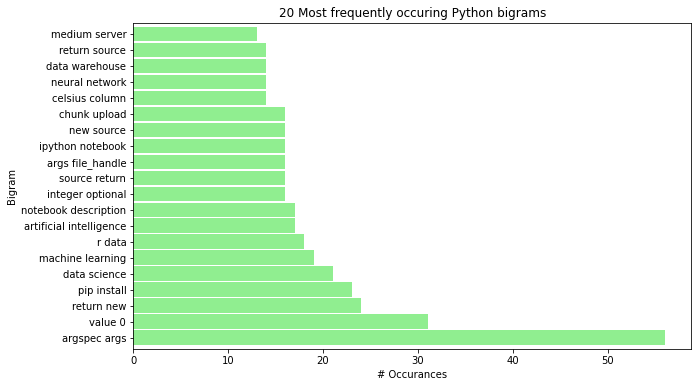

In [26]:
top_20_python_bigrams.plot.barh(color='lightgreen', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

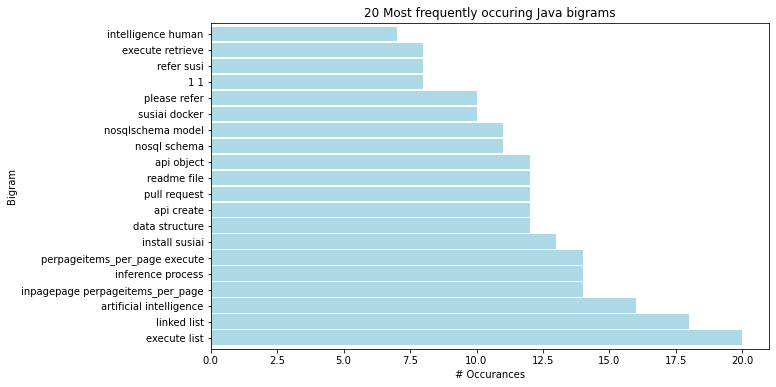

In [27]:
top_20_java_bigrams.plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Java bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_java_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

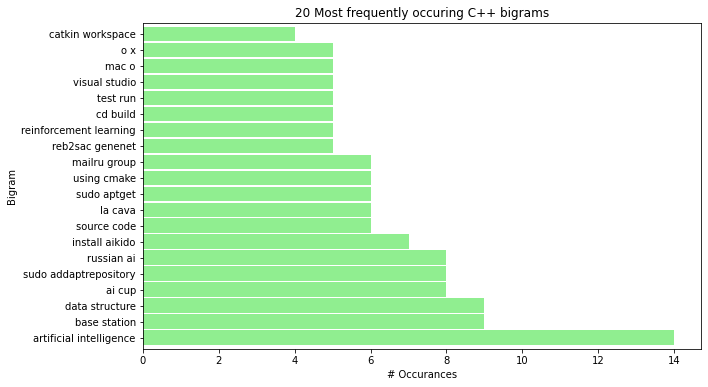

In [28]:
top_20_c_bigrams.plot.barh(color='lightgreen', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C++ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_c_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

**One interesting takeaway is that terms like data science and artificial intelligence occur frequently across all languages.**

# Bi-gram Word Cloud

(-0.5, 799.5, 399.5, -0.5)

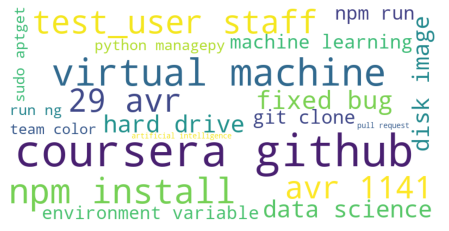

In [29]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

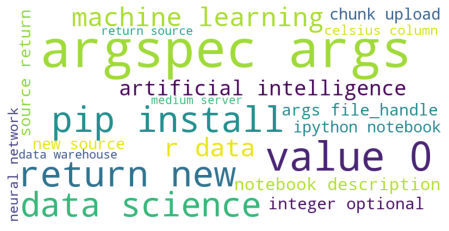

In [30]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

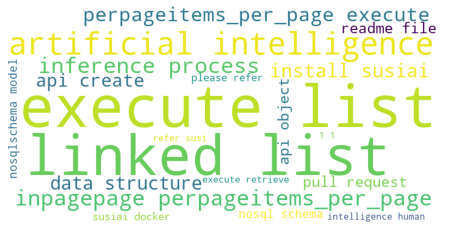

In [31]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_java_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

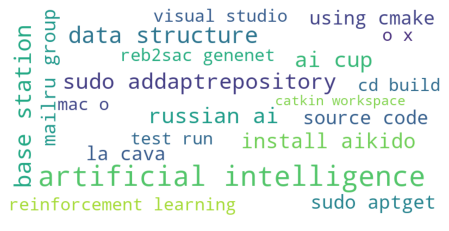

In [32]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_c_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

# Tri-grams

In [33]:
#Javascript
top_20_js_trigrams = (pd.Series(nltk.ngrams(js_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_js_trigrams.head()

(29, avr, 1141)           16
(avr, 1141, drwxrxrx)      7
(7, test_user, staff)      5
(aptget, update, sudo)     5
(sudo, aptget, update)     5
dtype: int64

In [34]:
#Python
top_20_python_trigrams = (pd.Series(nltk.ngrams(python_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_python_trigrams.head()

(return, new, source)                 15
(source, return, new)                 14
(return, source, return)              14
(ipython, notebook, demonstrating)    11
(new, source, example)                10
dtype: int64

In [35]:
#Java
top_20_java_trigrams = (pd.Series(nltk.ngrams(java_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_java_trigrams.head()

(inpagepage, perpageitems_per_page, execute)    14
(install, susiai, docker)                       10
(perpageitems_per_page, execute, list)           9
(please, refer, susi)                            8
(artificial, intelligence, human)                7
dtype: int64

In [36]:
#C++
top_20_java_trigrams = (pd.Series(nltk.ngrams(java_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_java_trigrams.head()

(inpagepage, perpageitems_per_page, execute)    14
(install, susiai, docker)                       10
(perpageitems_per_page, execute, list)           9
(please, refer, susi)                            8
(artificial, intelligence, human)                7
dtype: int64

______________________________________________________________________________________________

In [44]:
# Experimenting with some additional exploration techniques from the appendix.

In [37]:
import spacy

In [38]:
nlp = spacy.load('en_core_web_sm')

In [39]:
#Find the most frequent named entities in the corpus.
named_entities = []
for sentence in train.readme:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [45]:
#Transform and aggregate this data frame to find the top occuring entities and types.
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,RSS,1,2,first,3,two,one,Python,#,Kedro,Docker,Mycroft,AIKIDO,4,Dexcalibur
Entity Type,ORG,CARDINAL,CARDINAL,ORDINAL,CARDINAL,CARDINAL,CARDINAL,ORG,CARDINAL,PERSON,PERSON,PERSON,ORG,CARDINAL,ORG
Frequency,112,58,49,37,36,31,31,24,23,22,22,22,20,20,19


In [46]:
#Group by the entity types to get a sense of what types of entites occur most in our news corpus.
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,CARDINAL,GPE,DATE,PRODUCT,WORK_OF_ART,NORP,ORDINAL,LOC,FAC,MONEY,LAW,QUANTITY,TIME
Frequency,1531,970,776,300,168,152,147,92,91,43,40,30,19,15,13


In [47]:
#Visualize the named entities
from spacy import displacy

sentence = str(train.iloc[1].readme)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(nba, 'ORG'), (nba.com, 'ORG'), (npm, 'PERSON'), (install, 'PERSON'), (nba, 'ORG'), (NOTES, 'PERSON'), (CORS, 'ORG'), (NBA, 'ORG'), (IP, 'ORG'), (AWS, 'ORG'), (second, 'ORDINAL'), (NBA, 'ORG'), (NBA.com, 'ORG'), (AWS, 'ORG'), (Heroku, 'PERSON'), (NBA, 'ORG'), (JSON, 'ORG'), (JavaScript, 'PRODUCT'), (NBA.stats, 'NORP'), (NBA, 'ORG'), (Stephen, 'PERSON'), (playerId, 'CARDINAL'), (201939, 'DATE'), (teamId, 'CARDINAL'), (1610612744, 'DATE'), (Stephen, 'PERSON'), (Curry, 'PERSON'), (', 'PERSON'), (stephen, 'PERSON'), (curry, 'PERSON'), (', 'PERSON'), (JavaScript, 'ORG'), (HTTP, 'PRODUCT'), (NBA, 'ORG'), (NBA, 'ORG'), (NBA, 'ORG'), (NBA, 'ORG'), (HTTP, 'ORG'), (four, 'CARDINAL'), (sportVu, 'CARDINAL'), (HTTP, 'NORP'), (WNBA, 'ORDINAL'), (the, 'ORG'), (G, 'ORG'), (League, 'ORG'), (WNBA, 'ORG'), (require("nba, 'ORG'), (/, 'ORG'), (src, 'ORG'), (/, 'ORG'), (get, 'ORG'), (-, 'ORG'), (json, 'ORG'), (the, 'ORG'), (G, 'ORG'), (League, 'ORG'), (//, 'DATE'), (WNBA, 'ORDINAL'), (1628886, 'WORK_OF_ART